In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation

In [204]:
dt = 0.1

In [205]:
# Neuron population parameters
layer_distribution = [2, 12, 2]
n_layers = 3
neuron_types = ["TRN", "p23", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True]
dist_layer1 = np.array([1, 0, 0])
dist_layer2 = np.array([0, 8, 2])
dist_layer3 = np.array([1, 0, 0])
neuron_distribution = [dist_layer1, dist_layer2, dist_layer3]
threshold_decay = np.exp(-dt / 5)
layer_distances = np.zeros((n_layers, n_layers))
# mm
layer_distances[0, 0] = 0.6
layer_distances[1, 1] = 0.6
layer_distances[2, 2] = 0.6
layer_distances[0, 1] = 5.0
layer_distances[1, 0] = 5.0
layer_distances[1, 2] = 5.0
layer_distances[2, 1] = 5.0
layer_distances[0, 2] = 10.0
layer_distances[2, 0] = 10.0

In [206]:
neuron_pop = NeuronPopulation(
    layer_distribution,
    neuron_distribution,
    layer_distances,
    neuron_types,
    inhibitory,
    threshold_decay,
    threshold_mult=1.15
)

In [207]:
# Connectome
max_synapses = 12
synapse_strength = np.ones((n_layers, n_layers))
# neuron_types = ["p23", "TRN", "b", "nb"]
connectivity_probability = np.ones((n_layers, n_layers, n_neuron_types, n_neuron_types+2))


connectivity_probability[:,:,:,-2] = 0.0  # Self connections
connectivity_probability[:,:,:,-1] = 0.0  # No empty connections
# No inter-connections for input and output layers
connectivity_probability[0, 0, :, :-2] = 0
connectivity_probability[2, 2, :, :-2] = 0
# Only flow in one direction
connectivity_probability[1, 0, :, :-2] = 0.0
connectivity_probability[2, 1, :, :-2] = 0.0
connectivity_probability[2, 0, :, :-2] = 0.0
# No jump from input to output
connectivity_probability[0, 2, :, :-2] = 0.0

In [208]:
connectome = Connectome(
    max_synapses,
    neuron_pop,
    connectivity_probability,
    synapse_strength,
)

In [209]:
connectome.M

array([[12,  9,  2,  6, 13,  8,  6,  7,  8, 10, 13, 12],
       [13, 11,  6, 12, 11,  9, 11,  9,  6,  3, 10,  2],
       [13, 13,  3,  8, 11, 11, 14, 12,  9, 10,  5, 13],
       [ 5, 11, 14, 14, 10,  4, 15,  6, 15, 13, 15,  4],
       [ 9, 11, 14, 14,  9, 12,  3, 10, 12, 12, 12, 14],
       [ 6, 14, 15,  4, 12,  2, 10,  7, 11,  6, 14, 15],
       [11, 12, 15,  2,  8,  8,  5,  5,  5, 15, 12, 12],
       [15,  8, 15, 11, 10, 10, 10, 14, 13, 13, 12, 11],
       [15,  3,  7, 11, 11, 11, 11,  5, 11,  5,  7,  6],
       [15,  3,  2, 14, 10, 12, 11,  2, 11, 15,  3,  2],
       [ 4,  7, 13, 11, 13,  9,  7, 13,  4,  6,  6, 11],
       [13, 13,  4,  7,  3,  2,  3, 14, 12,  5,  6,  6],
       [10, 11,  2,  6,  9, 15,  9, 11, 15,  9,  7,  2],
       [11, 15,  6, 11, 11,  9,  7,  7,  6,  8,  5, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [212]:
connectome.NC

array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False

In [210]:
outw, inw, total = connectome.connections_per_neuron()
print("Connections per neuron:")
print("Out:", outw)
print("In:", inw)
print("Total:", total)

Connections per neuron:
Out: [12 12 12 12 12 12 12 12 12 12 12 12 12 12  0  0]
In: [ 0  0  7  6  4  6  9  7  5  7  9 12  9  7  7  8]
Total: [12 12 19 18 16 18 21 19 17 19 21 24 21 19  7  8]


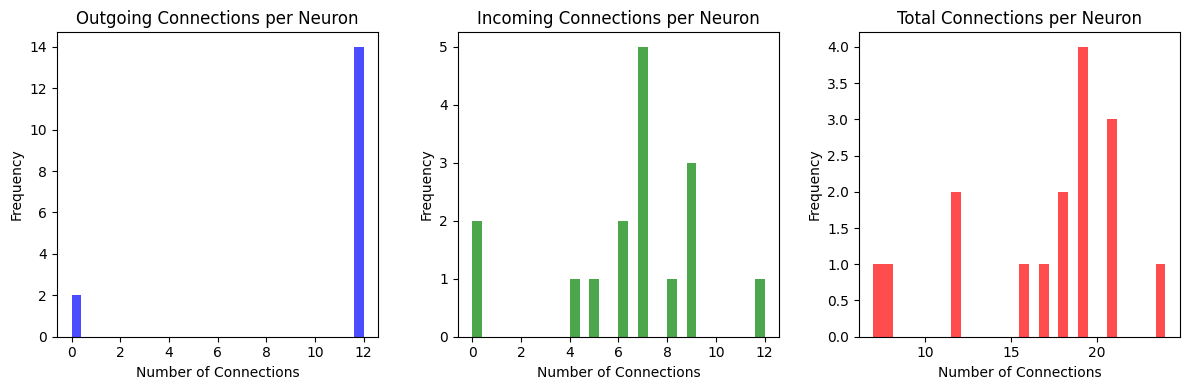

In [211]:
# Plot 3 connections histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(outw, bins=30, color='blue', alpha=0.7, label='Outgoing')
plt.title('Outgoing Connections per Neuron')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(inw, bins=30, color='green', alpha=0.7, label='Incoming')
plt.title('Incoming Connections per Neuron')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(total, bins=30, color='red', alpha=0.7, label='Total')
plt.title('Total Connections per Neuron')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [178]:
# connectome.distances

In [179]:
sim = Simulation(connectome, dt, stepper_type="adapt")
sim.plasticity.mirror_neurons = [(0, -2), (1, -1)]

In [180]:
weights_t0 = connectome.W.copy()

In [181]:
# connectome.W.copy()

In [182]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[1] = 100
I_ext[2:-2] = 50

# I_ext = 100

for i in range(50000):
    sim.step(I_ext=I_ext)

weights_t1 = connectome.W.copy()

In [183]:
# sim.plasticity.A = 0.0

In [184]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[0] = 100
I_ext[2:-2] = 50

# I_ext = 100

for i in range(50000):
    sim.step(I_ext=I_ext)

weights_t1 = connectome.W.copy()

In [185]:
# sim.plasticity.activity_trace

In [186]:
sim.synapse_dynamics.g_GABA_A
sim.synapse_dynamics.g_NMDA

array([0.00000000e+00, 0.00000000e+00, 2.81266980e-03, 2.20016781e-02,
       4.71118564e-04, 2.22916399e-02, 2.73288477e-02, 2.92122842e-03,
       5.04618429e-02, 9.87017925e-02, 1.00641911e-01, 1.41445910e-02,
       5.10366767e-02, 4.35829587e-03, 3.82166497e-02, 1.15385192e-10])

In [187]:
neuron_pop.inhibitory_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [188]:
sim.neuron_states.V

array([-50.5547192 , -53.30036711, -56.85649646, -57.98409941,
       -57.59110255, -57.81308348, -56.23075015, -57.45123117,
       -59.10397784, -56.3096    , -57.41445085, -58.44410976,
       -58.92649917, -58.7267706 , -62.22456255, -54.09761555])

In [189]:
weights_t1 # [neuron_pop.inhibitory_mask]

array([[2.49894762e-02, 3.78902334e-02, 7.80813320e-03, 5.39233507e-02,
        1.32819267e-02, 6.15973880e-03, 1.02974553e-02, 1.41849069e-02,
        5.80040535e-03, 2.68581376e-03, 1.12850414e-02, 6.90472934e-03],
       [5.71900725e-03, 1.55045632e-02, 1.64405419e-02, 1.72826669e-02,
        2.65141329e-02, 5.19568081e-03, 0.00000000e+00, 2.28791367e-02,
        2.20056024e-02, 3.35430212e-03, 1.87380991e-02, 4.90802281e-03],
       [3.19684232e-02, 3.47189095e-01, 2.24667554e-02, 0.00000000e+00,
        5.05031810e-02, 4.96771316e-02, 6.04864490e-02, 5.56184729e-02,
        6.66847149e-02, 8.02556074e-02, 1.02270406e-01, 6.76468858e-02],
       [9.63183724e-02, 4.77554201e-02, 5.94797829e-02, 4.15046143e-01,
        6.27153765e-02, 3.94795472e-01, 7.62540737e-02, 6.32950810e-02,
        5.73773004e-03, 7.49404158e-02, 1.43749176e-01, 1.11455976e-01],
       [2.79243504e-02, 3.95504457e-02, 8.36956437e-02, 1.16027363e-01,
        2.55300915e-02, 1.26517483e+00, 2.46601810e-02, 1.45

In [190]:
weights_t1 -   weights_t0

array([[-1.55583271, -1.81560919, -0.87898576, -1.2782327 , -0.72229928,
        -0.3823916 , -1.12147283, -0.67970675, -0.67182682, -0.30235038,
        -1.30707993, -0.79973416],
       [-0.33530798, -0.49563602, -0.49023125, -0.81902681, -1.40373055,
        -0.66918268,  0.        , -1.34141412, -1.02551571, -0.21999587,
        -0.59672928, -0.52577401],
       [-0.62696669, -0.51127463, -0.26698882,  0.        , -1.00462763,
        -0.97427097, -0.88992383, -1.10638287, -1.4289558 , -1.54299978,
        -1.1785169 , -1.26195007],
       [-1.81143424, -0.84490696, -0.33140286,  0.03118683, -1.11142468,
         0.02966518, -1.34911591, -1.12169804, -0.03196885, -1.04402677,
        -1.24146923, -0.62099804],
       [-0.54857162, -0.43777588, -1.57293361, -0.64631637, -0.48595231,
         0.09086897, -0.34343255, -0.20254437, -0.332556  , -0.77720508,
        -0.46568707, -1.74473692],
       [-0.6423858 , -1.34271147, -1.22093152,  0.        , -1.08604143,
        -1.52028479, -

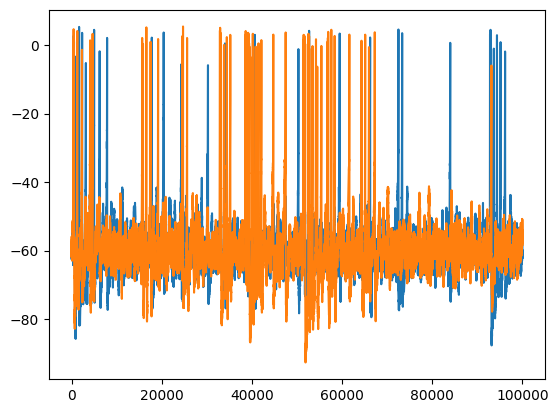

In [191]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()

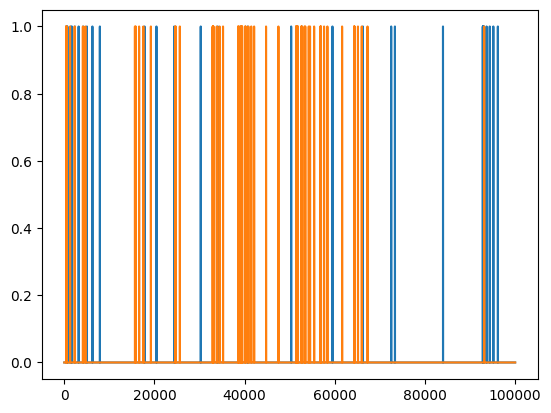

In [192]:
plt.plot(np.array(sim.stats.spikes)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()